# Модельная траектория
заменить потом возможно на ballistic simulator

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory_1d(timestamps, data, coord_name=''):
    if (len(timestamps) != len(data)):
        print('plot_trajectory_1d(): '\
              f'expected matching input lengths, got {len(timestamps)}, {len(data)} instead.')
        return None

    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.plot(timestamps, data)
    ax.set_xlabel('Время, сек')
    ax.set_ylabel(f'Координата {coord_name}, м')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


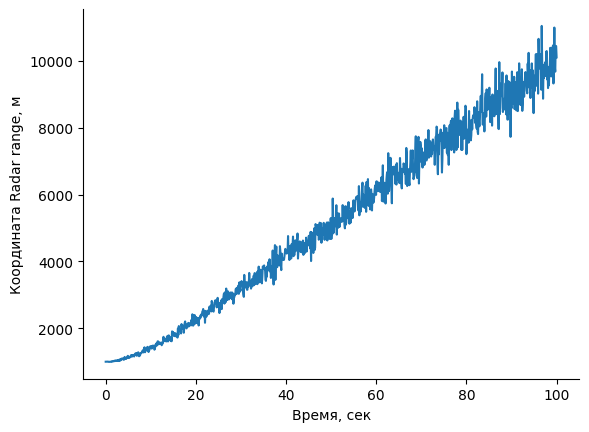

In [2]:
import math
from numpy.random import randn

def get_ranges(N: int, pos=0., vel=100., alt=1000., dt=0.1):
    """ 
    Симуляция измерения расстояния радаром
    N - требуемое число измерений
    """
    dists = []
    for n in range(N): 
        vel = vel  + .1*randn()
        alt = alt + .1*randn()
        pos = pos + vel*dt
    
        err = pos * 0.05*randn()
        slant_dist = math.sqrt(pos**2 + alt**2)
        
        dists.append(slant_dist + err)

    return np.asarray(dists)

r_n = get_ranges(N=1000).reshape(-1, 1)

t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, r_n, coord_name='Radar range')

# Фильтрация традиционными фильтрами

См library_testing

# Фильтрация M3H 

In [3]:
def hx(x):
    """ Пересчёт состояния x в измерение расстояния """
    
    return (x[0]**2 + x[2]**2) ** 0.5

from math import sqrt
def HJacobian_at(x):
    """ Расчёт Якобиана в данной задаче для x = [x, dx/dt, y] """

    horiz_dist = x[0] # x
    altitude   = x[2] # y
    denom = sqrt(horiz_dist**2 + altitude**2)
    return np.array ([[horiz_dist/denom, 0., altitude/denom]])

In [4]:
from FilterLib.EKF import EKF

import scipy
import numpy as np

dt = 0.1
x0 = np.array([1700, 100, 1000]).T
P = np.array([
    [100., 0, 0],
    [0, 100., 0],
    [0, 0, 100]
])

F = np.array(
    [[1., dt, 0],
     [0, 1., 0],
     [0, 0, 1]]
)

Q = scipy.linalg.block_diag(
    [[.25*dt**4, .5*dt**3],
    [ .5*dt**3,    dt**2]],
                           [0.1]
    )

R = np.array([25])

kf1 = EKF(
    dim_x=3,
    dim_m=1,
    HJacobian=HJacobian_at,
    h=hx,
    P=P,
    F=F,
    Q=Q,
    R=R,
    x0=x0,
    dt=dt
)

kf2 = EKF(
    dim_x=3,
    dim_m=1,
    HJacobian=HJacobian_at,
    h=hx,
    P=P,
    F=F,
    Q=Q,
    R=R,
    x0=x0,
    dt=dt
)

kf1.add_measurement(data=r_n)
kf2.add_measurement(data=r_n)
#kf1.predict()
#kf1.update()


In [5]:
from M3H import MMMH

filters = [kf1, kf2]
trans   = np.array([[0.97, 0.03],
                    [0.03, 0.97]])

mmmh = MMMH(filters=filters, Probas=trans, l_max=10, L=5, eps=0.01)

outs = []
for i in range(len(r_n)):
    mmmh._expand()
    #mmmh.hypotheses

    mmmh._merge()
    #mmmh.hypotheses

    mmmh._prune()
    #print(mmmh.hypotheses)

    mmmh.predict()

    mmmh.update()
    #print(mmmh.hypotheses)

    outs.append(mmmh.output())

In [6]:
mmmh.hypotheses

[Hypothesis object
 Modal history: [0, 0, 0, 0, 0]
 Likelihood: 0.25,
 Hypothesis object
 Modal history: [0, 1, 1, 1, 1]
 Likelihood: 0.25,
 Hypothesis object
 Modal history: [1, 0, 0, 0, 0]
 Likelihood: 0.25,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1]
 Likelihood: 0.25]

(1000, 3)


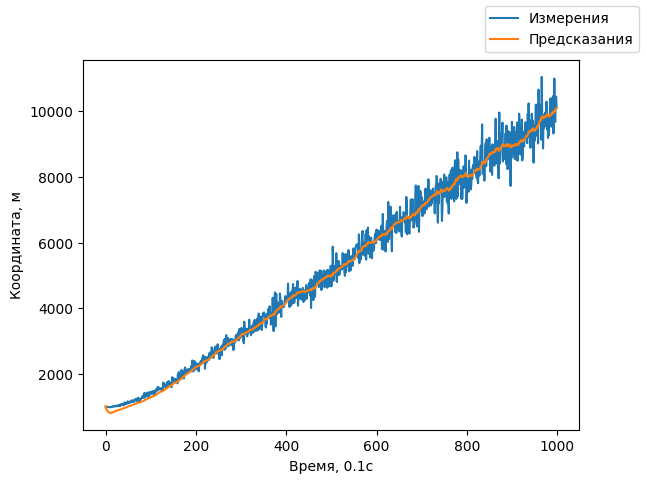

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

outs = np.asarray(outs)
print(outs.shape)
ax.plot(r_n[:], label='Измерения')
ax.plot(outs[:, 0], label='Предсказания')
ax.set_xlabel('Время, 0.1с')
ax.set_ylabel('Координата, м')
fig.legend()

In [8]:
mmmh._expand()
mmmh.hypotheses

[Hypothesis object
 Modal history: [0, 0, 0, 0, 0, 0]
 Likelihood: 0.2425,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 0, 1]
 Likelihood: 0.0075,
 Hypothesis object
 Modal history: [0, 1, 1, 1, 1, 0]
 Likelihood: 0.0075,
 Hypothesis object
 Modal history: [0, 1, 1, 1, 1, 1]
 Likelihood: 0.2425,
 Hypothesis object
 Modal history: [1, 0, 0, 0, 0, 0]
 Likelihood: 0.2425,
 Hypothesis object
 Modal history: [1, 0, 0, 0, 0, 1]
 Likelihood: 0.0075,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1, 0]
 Likelihood: 0.0075,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1, 1]
 Likelihood: 0.2425]

In [9]:
mmmh.print_hypotheses_estimations()

----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0, 0]
Likelihood: 0.2425
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0, 1]
Likelihood: 0.0075
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 1, 1, 1, 1, 0]
Likelihood: 0.0075
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 1, 1, 1, 1, 1]
Likelihood: 0.2425
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 0, 0, 0, 0, 0]
Likelihood: 0.2425
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 0, 0, 0, 0, 1]
Likelihood: 0.0075
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 1, 1, 0]
Likelihood: 0.0075
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 1, 1, 1]
Likeli

In [10]:
mmmh._merge()
mmmh.hypotheses

[Hypothesis object
 Modal history: [0, 0, 0, 0, 0]
 Likelihood: 0.485,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 1]
 Likelihood: 0.015,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 0]
 Likelihood: 0.015,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1]
 Likelihood: 0.485]

In [11]:
mmmh._expand()
mmmh.hypotheses

[Hypothesis object
 Modal history: [0, 0, 0, 0, 0, 0]
 Likelihood: 0.47045,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 0, 1]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 1, 0]
 Likelihood: 0.00045,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 1, 1]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 0, 0]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 0, 1]
 Likelihood: 0.00045,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1, 0]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1, 1]
 Likelihood: 0.47045]

In [12]:
mmmh._merge()
mmmh.hypotheses

[Hypothesis object
 Modal history: [0, 0, 0, 0, 0]
 Likelihood: 0.47045,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 1]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [0, 0, 0, 1, 0]
 Likelihood: 0.00045,
 Hypothesis object
 Modal history: [0, 0, 0, 1, 1]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 0, 0]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 0, 1]
 Likelihood: 0.00045,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 0]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1]
 Likelihood: 0.47045]

In [13]:
mmmh.print_hypotheses_estimations()

----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0]
Likelihood: 0.47045
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 0, 1]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 1, 0]
Likelihood: 0.00045
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 1, 1]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 0, 0]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 0, 1]
Likelihood: 0.00045
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 1, 0]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Mo

In [14]:
mmmh.predict()
mmmh.hypotheses

Error! No more data!
Error! No more data!
Error! No more data!
Error! No more data!
Error! No more data!
Error! No more data!
Error! No more data!
Error! No more data!


[Hypothesis object
 Modal history: [0, 0, 0, 0, 0]
 Likelihood: 0.47045,
 Hypothesis object
 Modal history: [0, 0, 0, 0, 1]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [0, 0, 0, 1, 0]
 Likelihood: 0.00045,
 Hypothesis object
 Modal history: [0, 0, 0, 1, 1]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 0, 0]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 0, 1]
 Likelihood: 0.00045,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 0]
 Likelihood: 0.014549999999999999,
 Hypothesis object
 Modal history: [1, 1, 1, 1, 1]
 Likelihood: 0.47045]

In [15]:
mmmh.print_hypotheses_estimations()

----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0]
Likelihood: 0.47045
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 0, 1]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 1, 0]
Likelihood: 0.00045
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [0, 0, 0, 1, 1]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 0, 0]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 0, 1]
Likelihood: 0.00045
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Modal history: [1, 1, 1, 1, 0]
Likelihood: 0.014549999999999999
x = [10091.68023058   120.54762046   577.04226521]
----------
Hypothesis object
Mo

In [16]:
mmmh.update()
mmmh.print_hypotheses_estimations()

Error! Double call of update!


LinAlgError: Singular matrix

In [ ]:
mmmh.output()

array([1030.03901114,   32.67378034,  605.90540132])

In [ ]:
mmmh._expand()
mmmh._merge()
mmmh._prune()
mmmh.print_hypotheses_estimations()

----------
Hypothesis object
Modal history: [0, 0, 0, 0]
Likelihood: 0.485
x = [1030.03901114   32.67378034  605.90540132]
----------
Hypothesis object
Modal history: [0, 0, 1, 1]
Likelihood: 0.485
x = [1030.03901114   32.67378034  605.90540132]
----------
Hypothesis object
Modal history: [0, 0, 0, 1]
Likelihood: 0.015
x = [1030.03901114   32.67378034  605.90540132]


In [ ]:
mmmh.predict()
mmmh.update()
mmmh.output()

array([953.28974164, -11.47011439, 563.43058596])

In [ ]:
mmmh.print_hypotheses_estimations()

----------
Hypothesis object
Modal history: [0, 0, 0, 0]
Likelihood: 0.3333333333333333
x = [953.28974164 -11.47011439 563.43058596]
----------
Hypothesis object
Modal history: [0, 0, 1, 1]
Likelihood: 0.3333333333333333
x = [953.28974164 -11.47011439 563.43058596]
----------
Hypothesis object
Modal history: [0, 0, 0, 1]
Likelihood: 0.3333333333333333
x = [953.28974164 -11.47011439 563.43058596]


In [ ]:
for i in range(5):
    mmmh._expand()
    mmmh._merge()
    mmmh._prune()

    mmmh.predict()
    mmmh.update()
    #print(mmmh.output())
    mmmh.print_hypotheses_estimations()
    print()

----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
Likelihood: 0.3333333333333333
x = [867.59084903  -0.97466734 492.2289861 ]
----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Likelihood: 0.3333333333333333
x = [867.59084903  -0.97466734 492.2289861 ]
----------
Hypothesis object
Modal history: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# !!!!!!!!!! only one of the hypothesis with equal likelihood is selected!!!!!
mmmh._prune()
mmmh.hypotheses


Removing hypothesis Hypothesis object
Modal history: [0, 0, 0, 1]
Likelihood: 0.009408999999999999
Removing hypothesis Hypothesis object
Modal history: [0, 0, 1, 0]
Likelihood: 0.00029099999999999997
Removing hypothesis Hypothesis object
Modal history: [0, 0, 1, 1]
Likelihood: 0.009408999999999999
Removing hypothesis Hypothesis object
Modal history: [0, 1, 0, 0]
Likelihood: 0.0002909999999999999
Removing hypothesis Hypothesis object
Modal history: [0, 1, 0, 1]
Likelihood: 8.999999999999997e-06
Removing hypothesis Hypothesis object
Modal history: [0, 1, 1, 0]
Likelihood: 0.00029099999999999997
Removing hypothesis Hypothesis object
Modal history: [0, 1, 1, 1]
Likelihood: 0.009408999999999999
Removing hypothesis Hypothesis object
Modal history: [1, 0, 0, 1]
Likelihood: 0.0005819999999999999
Removing hypothesis Hypothesis object
Modal history: [1, 0, 1, 0]
Likelihood: 1.7999999999999994e-05
Removing hypothesis Hypothesis object
Modal history: [1, 0, 1, 1]
Likelihood: 0.0005819999999999998


[Hypothesis object
 Modal history: [1, 1, 1, 1]
 Likelihood: 0.6084486666666666,
 Hypothesis object
 Modal history: [0, 0, 0, 0]
 Likelihood: 0.3042243333333333,
 Hypothesis object
 Modal history: [1, 0, 0, 0]
 Likelihood: 0.018817999999999998]